In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import vaex
from functools import lru_cache

import sys

sys.path.append("../../../")

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data, plot_efficiency_map_scattered
from utils.optimization import plot_compare, save_model_params_to_json, load_model_params_from_json
from utils.control import get_steady_state_map
from utils.data import get_events, get_sections, load_df, export_dataframe_to_latex

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Data

In [33]:
generation_params = load_model_params_from_json(
    "../../../models/2020/generation/generation_params.json"
)

In [34]:
%%time

filename = "../../../models/2020/boat_data_50ms.csv"
rename_columns = {
    "Battery Pack Voltage": "batt_v",
    "Battery Current": "batt_i",
    "ESC Duty Cycle": "esc_d",
    "Motor Angular Speed": "motor_w",
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    # **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    'Solar POA': 'pv_g',
}

df = vaex.from_csv(filename)[["timestamp", *rename_columns.keys()]].to_pandas_df().rename(columns=rename_columns)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"])
df = df.set_index("timestamp", drop=True)
df = df.interpolate(method="time", limit=50, limit_area="inside", limit_direction="both")
df = df.resample("1s").mean()
df["t"] = df.index.to_series().diff().median().total_seconds() * np.arange(len(df.index))
df = df[["t", *rename_columns.values()]]

display(df.describe())

t         batt_v        batt_i          esc_d  \
count  350931.000000  121690.000000  62944.000000  350931.000000   
mean   175465.000000      39.071466     -0.695038       0.031673   
std    101305.197996       3.066150     14.274368       0.124286   
min         0.000000      25.958081    -31.177000       0.000000   
25%     87732.500000      37.677105     -3.000000       0.000000   
50%    175465.000000      38.588646      0.000000       0.000000   
75%    263197.500000      39.689748      0.000000       0.000000   
max    350930.000000      49.405243    146.102000       1.000000   

             motor_w    mppt1_i_in    mppt2_i_in    mppt3_i_in    mppt4_i_in  \
count   1.441590e+05  97877.000000  86564.000000  98424.000000  94941.000000   
mean    2.428341e+01      3.378617      3.895305      3.811378      3.664079   
std     5.738996e+01      2.957743      3.018669      3.079338      2.954152   
min     0.000000e+00     -0.022499     -0.033310     -0.041297     -0.030122   
25%     0.000000e+00      1.166547      1.534103      1.456992      1.437658   
50%     0.000000e+00      2.262919      2.733981      2.494390      2.516364   
75%    4.800018e-245      5.393372      6.635658      6.174942      6.100294   
max     3.741353e+02     17.060413     12.610743     14.536313     12.256176   

         mppt1_v_in    mppt2_v_in    mppt3_v_in    mppt4_v_in        mppt1_d  \
count  98898.000000  86980.000000  98933.000000  98890.000000  125050.000000   
mean      24.760492     25.563317     25.901847     24.794208       0.590773   
std        7.806939      5.733572      7.712278      7.720007       0.133813   
min       -0.153051     -0.086031     -0.193900     -0.036741      -0.001934   
25%       25.728319     25.871898     26.606778     25.793599       0.576996   
50%       27.310930     26.959737     27.875133     27.120700       0.599766   
75%       28.296673     27.763066     28.971077     28.172054       0.623188   
max       53.293536     39.439830     38.689999     36.192469       0.957908   

             mppt2_d        mppt3_d        mppt4_d           pv_g  
count  114753.000000  125050.000000  125050.000000  350744.000000  
mean        0.557620       0.562733       0.567039     220.442385  
std         0.125267       0.134363       0.143546     303.221240  
min        -0.001741      -0.002222      -0.001423       0.000000  
25%         0.575998       0.581297       0.575429       0.000000  
50%         0.589198       0.601488       0.588745      45.048208  
75%         0.614458       0.620266       0.617033     392.493816  
max         0.913659       0.882525       0.938836    1025.560699

CPU times: user 33.8 s, sys: 2.29 s, total: 36 s
Wall time: 33.5 s


Train size ≃ 0.00%
Test  size ≃ 100.00%


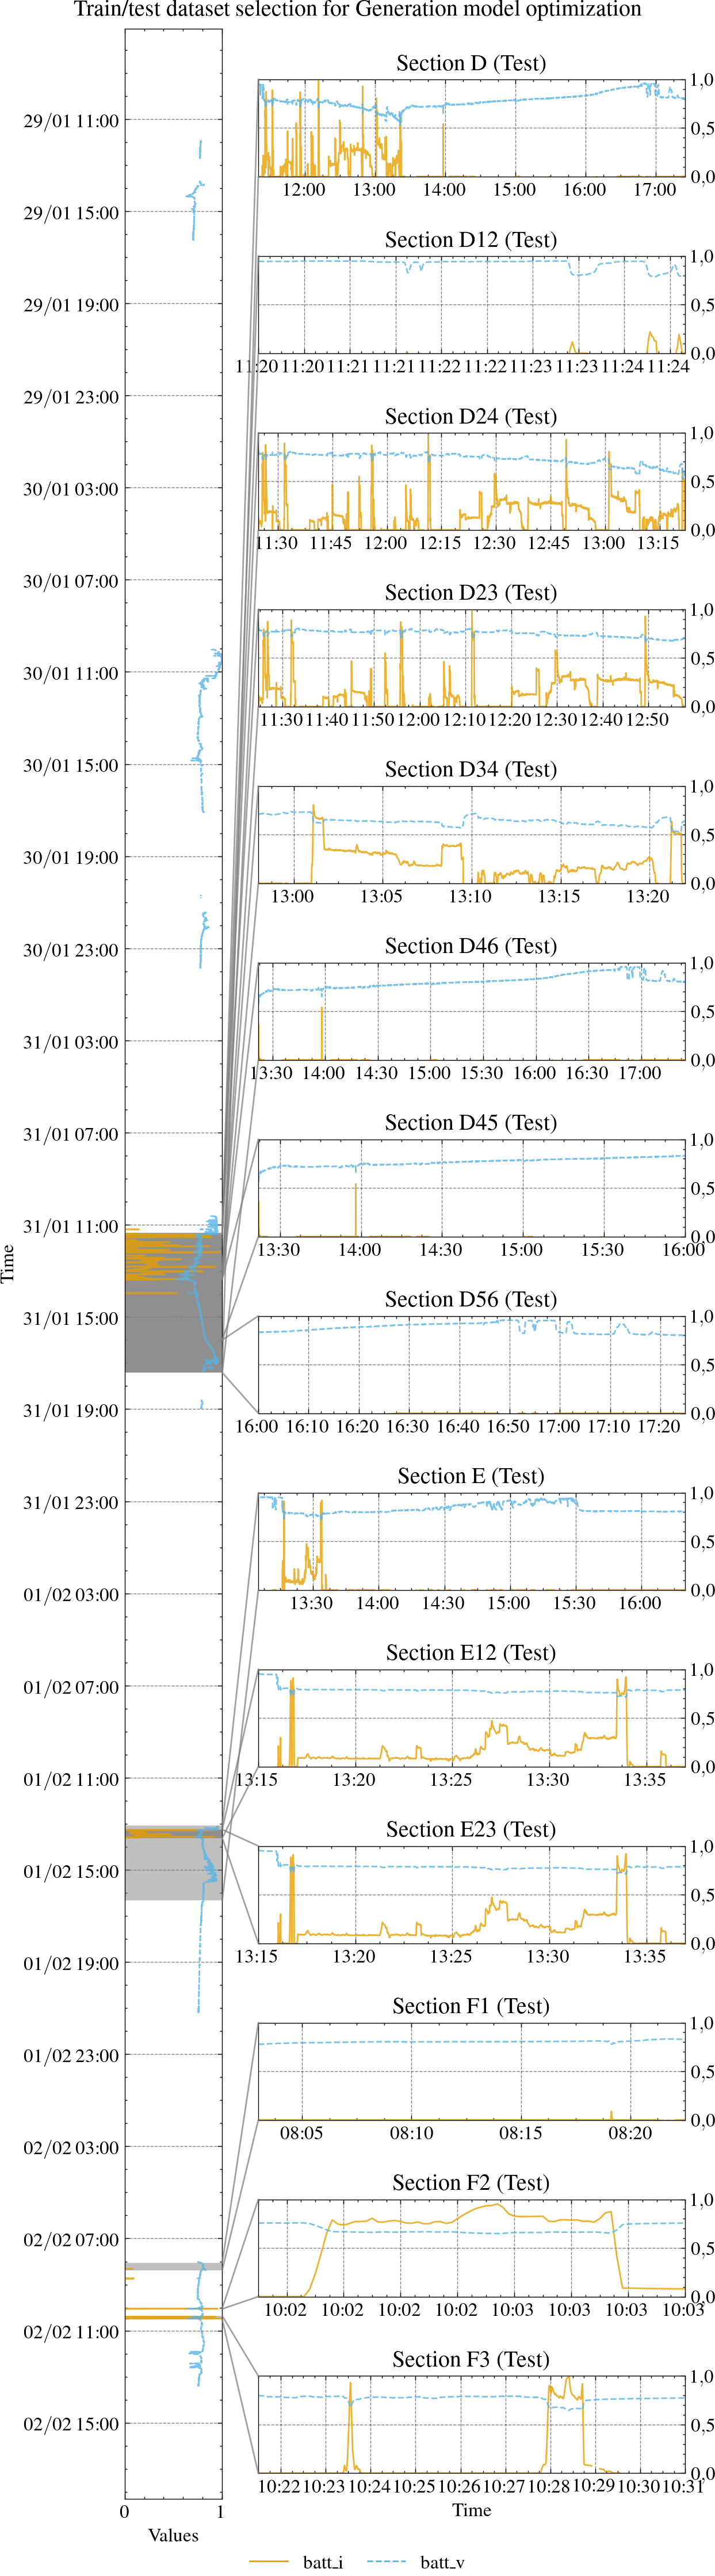

In [35]:
sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp(
    "2020-01-31 11:20:00"
)  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp("2020-01-31 11:24:40")  # start of the race
D3 = pd.Timestamp("2020-01-31 12:58:00")  # battery enters in deep-discharge
D4 = pd.Timestamp("2020-01-31 13:22:00")  # race finishes, post-race charge starts
D5 = pd.Timestamp("2020-01-31 16:00:00")  # overcharge starts
D6 = pd.Timestamp("2020-01-31 17:24:55")  # end of the day
sections.loc["Section D"] = [D1, D6]  # Full race event
sections.loc["Section D12"] = [D1, D2]  # Full pre-race charge
sections.loc["Section D24"] = [D2, D4]  # Full race discharge
sections.loc["Section D23"] = [D2, D3]  # Race normal discharge range
sections.loc["Section D34"] = [D3, D4]  # Race deep-discharge range
sections.loc["Section D46"] = [D4, D6]  # Full post-race charge
sections.loc["Section D45"] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc["Section D56"] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc["Section E"] = [
    pd.Timestamp("2020-02-01 13:05:00"),
    pd.Timestamp("2020-02-01 16:20:00"),
]  # A quick 15min discharge followed by an overcharge
sections.loc["Section E12"] = [
    pd.Timestamp("2020-02-01 13:15:00"),
    pd.Timestamp("2020-02-01 13:37:00"),
]  # A ~15min discharge
sections.loc["Section E23"] = [
    pd.Timestamp("2020-02-01 13:15:00"),
    pd.Timestamp("2020-02-01 13:37:00"),
]  # Another over-charging section
sections.loc["Section F1"] = [
    pd.Timestamp("2020-02-02 8:03:00"),
    pd.Timestamp("2020-02-02 8:22:30"),
]  # A quick charge section
sections.loc["Section F2"] = [
    pd.Timestamp("2020-02-02 10:02:15"),
    pd.Timestamp("2020-02-02 10:03:30"),
]  # 2min high-current pulse
sections.loc["Section F3"] = [
    pd.Timestamp("2020-02-02 10:21:30"),
    pd.Timestamp("2020-02-02 10:31:00"),
]  # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[
    [
        "Section D",
        "Section D12",
        "Section D24",
        "Section D23",
        "Section D34",
        "Section D46",
        "Section D45",
        "Section D56",
        "Section E",
        "Section E12",
        "Section E23",
        "Section F1",
        "Section F2",
        "Section F3",
    ]
]

train_sections_names = []

train_test_sections = sections.reset_index().to_dict(orient="records")
train_sections = (
    sections.loc[sections.index.intersection(train_sections_names)]
    .reset_index()
    .to_dict(orient="records")
)
test_sections = (
    sections.loc[sections.index.difference(train_sections_names)]
    .reset_index()
    .to_dict(orient="records")
)
all_sections = sections.reset_index().to_dict(orient="records")

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec["start"]) & (df.index <= sec["end"])
    if sec["name"] in train_sections_names:
        sec["name"] = sec["name"] + " (Train)"
        train_mask |= mask
    else:
        sec["name"] = sec["name"] + " (Test)"
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f"Train size ≃ {100*train_size/total_size:.2f}%")
print(f"Test  size ≃ {100*test_size/total_size:.2f}%")

fig_save_and_show(
    filename=None,  # f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
    show_title=f"Train/test dataset selection for Generation model optimization",
    save_title=f"Dataset da embarcação durante o DSB de 2019",
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=["batt_i", "batt_v"],
        normalize=True,
    ),
)

# Solar Boat System Models

In [36]:
generation_params = load_model_params_from_json('../../../models/2020/generation/generation_params.json')
battery_params = load_model_params_from_json('../../../models/2020/battery/PNGV_2rc_params.json')
propulsion_params = load_model_params_from_json('../../../models/2020/propulsion/propulsion_params.json')

others_params = {
    "oth_p_in": 1.5 * 18,
}

solar_boat_params = (
    generation_params | battery_params | propulsion_params | others_params
)
save_model_params_to_json('solar_boat_params.json', solar_boat_params)

solar_boat_params

{'mppt_eta': 0.9323459474182263,
 'mppts_n': 4,
 'pv_S': 1.6367999999999998,
 'pv_eta': 0.14309907292684962,
 'batt_C_1': 763.5350737712305,
 'batt_C_2': 212113.61911925237,
 'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_R_0': 0.004833021318920369,
 'batt_R_1': 0.005009783862137879,
 'batt_R_2': 0.09739310817004393,
 'batt_eta': 1,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218]),
 'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.006428129677311848,
 'esc_V_F': 2.884681806089211,
 'esc_V_ds_ov': 1.2222222222222223,
 'esc_r_D': 0.003448696395697723,
 'hull_C_T': 0.010164657977504103,
 'hull_M': 293.7,
 'hull_M_a': 0.13930375506724846,
 'hull_S_air': 4.188174709710495,
 'hull_S_water': 4.050226176680205,
 'hull_T_ded': 0.048239289362583315,
 'hull_W': 0.09274643880385036,
 'motor_B': 0.001401819826389131,
 'motor_I_r': 0.011815137847671575,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10638460838741098,
 'motor_K_V

In [37]:
from model import SolarBoat, SolarBoatFull, SolarBoatInternalSignalModel
from utils.models import eval_poly

display(SolarBoat.build(solar_boat_params))
display(SolarBoatFull.build(solar_boat_params))
display(SolarBoatInternalSignalModel.build(solar_boat_params))

<NonlinearIOSystem solarboat: ['pv_g', 'esc_d'] -> ['batt_v', 'batt_i', 'mppts_i_out', 'motor_w', 'esc_i_in', 'hull_u']>

<NonlinearIOSystem solarboat_full: ['pv_g', 'esc_d'] -> ['batt_v', 'batt_i', 'batt_v_C_1', 'batt_v_C_2', 'batt_z', 'batt_v_oc', 'batt_p_out', 'batt_p_in', 'pv_p_in', 'pv_p_out', 'pv_eta', 'pv_g', 'mppt1_i_in', 'mppt1_v_in', 'mppt1_p_in', 'mppt1_v_out', 'mppt1_i_out', 'mppt1_p_out', 'mppt2_i_in', 'mppt2_v_in', 'mppt2_p_in', 'mppt2_v_out', 'mppt2_i_out', 'mppt2_p_out', 'mppt3_i_in', 'mppt3_v_in', 'mppt3_p_in', 'mppt3_v_out', 'mppt3_i_out', 'mppt3_p_out', 'mppt4_i_in', 'mppt4_v_in', 'mppt4_p_in', 'mppt4_v_out', 'mppt4_i_out', 'mppt4_p_out', 'pvs_p_in', 'pvs_p_out', 'pvs_i_out', 'mppt_p_in', 'mppt_p_out', 'mppt_v_in', 'mppt_v_out', 'mppt_i_in', 'mppt_i_out', 'mppt_eta', 'mppts_p_in', 'mppts_p_out', 'mppts_i_out', 'esc_v_in', 'esc_v_out', 'esc_i_in', 'esc_i_out', 'esc_p_in', 'esc_p_out', 'esc_eta', 'esc_p_loss', 'esc_p_M_cond', 'esc_p_D_cond', 'esc_p_M_sw', 'esc_p_D_sw', 'esc_i_M_RMS', 'esc_i_D_RMS', 'esc_i_D_AVG', 'motor_i', 'motor_v', 'motor_w', 'motor_q_load', 'motor_p_in', 'motor_p_out'

<NonlinearIOSystem solarboat_internal_signals: ['batt_v', 'esc_d', 'mppt1_i_in', 'mppt1_v_in', 'mppt2_i_in', 'mppt2_v_in', 'mppt3_i_in', 'mppt3_v_in', 'mppt4_i_in', 'mppt4_v_in'] -> ['batt_v', 'batt_i', 'batt_v_C_1', 'batt_v_C_2', 'batt_z', 'batt_v_oc', 'batt_p_out', 'batt_p_in', 'pv_p_in', 'pv_p_out', 'pv_eta', 'pv_g', 'mppt1_i_in', 'mppt1_v_in', 'mppt1_p_in', 'mppt1_v_out', 'mppt1_i_out', 'mppt1_p_out', 'mppt2_i_in', 'mppt2_v_in', 'mppt2_p_in', 'mppt2_v_out', 'mppt2_i_out', 'mppt2_p_out', 'mppt3_i_in', 'mppt3_v_in', 'mppt3_p_in', 'mppt3_v_out', 'mppt3_i_out', 'mppt3_p_out', 'mppt4_i_in', 'mppt4_v_in', 'mppt4_p_in', 'mppt4_v_out', 'mppt4_i_out', 'mppt4_p_out', 'pvs_p_in', 'pvs_p_out', 'pvs_i_out', 'mppt_p_in', 'mppt_p_out', 'mppt_v_in', 'mppt_v_out', 'mppt_i_in', 'mppt_i_out', 'mppt_eta', 'mppts_p_in', 'mppts_p_out', 'mppts_i_out', 'esc_v_in', 'esc_v_out', 'esc_i_in', 'esc_i_out', 'esc_p_in', 'esc_p_out', 'esc_eta', 'esc_p_loss', 'esc_p_M_cond', 'esc_p_D_cond', 'esc_p_M_sw', 'esc_p_D_

In [38]:
def simulate_solar_boat(df, model_params):
    model = SolarBoatFull
    model_params = solar_boat_params.copy()

    # Model
    solar_boat = model.build(model_params)
    input_cols = solar_boat.input_labels

    # Time array
    T = np.ascontiguousarray(df["t"].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df[input_cols].to_numpy().T)

    # Initial state
    X0 = model.initial_state(
        X0={
            "batt_z": 1.2,
            "batt_v": float(df["batt_v"].iloc[0]),
        },
        U0=U[:, 0],
        params=model_params,
    )

    # Simulation
    res = ct.input_output_response(
        solar_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau"
    )
    df_out = res.to_pandas()
    df_out['t'] = df_out['time'] - df_out['time'].iloc[0]

    return df_out.set_index("time")

In [39]:
def estimate_solar_boat_signals(df, model_params):
    model = SolarBoatInternalSignalModel
    model_params = solar_boat_params.copy()

    # Model
    solar_boat = model.build(model_params)

    # Time array
    T = np.ascontiguousarray(df["t"].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df[solar_boat.input_labels].to_numpy().T)

    # Initial state
    X0 = model.initial_state(
        X0={"batt_z": 1.2, "batt_v": float(df["batt_v"].iloc[0])},
        U0=U[:, 0],
        params=model_params,
    )

    # Simulation
    res = ct.input_output_response(
        solar_boat, T=T, U=U, X0=X0, solve_ivp_method="Radau"
    )
    df_out = res.to_pandas()
    df_out['t'] = df_out['time'] - df_out['time'].iloc[0]

    return df_out.set_index("time")


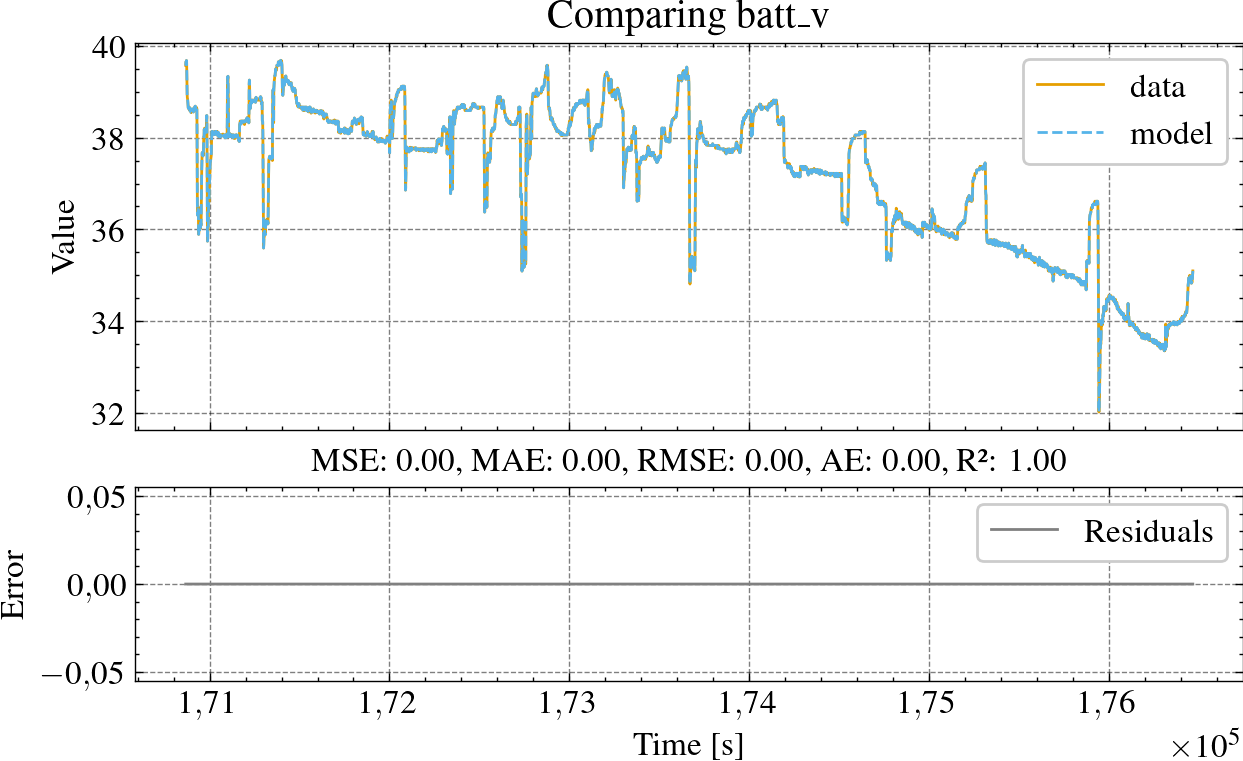

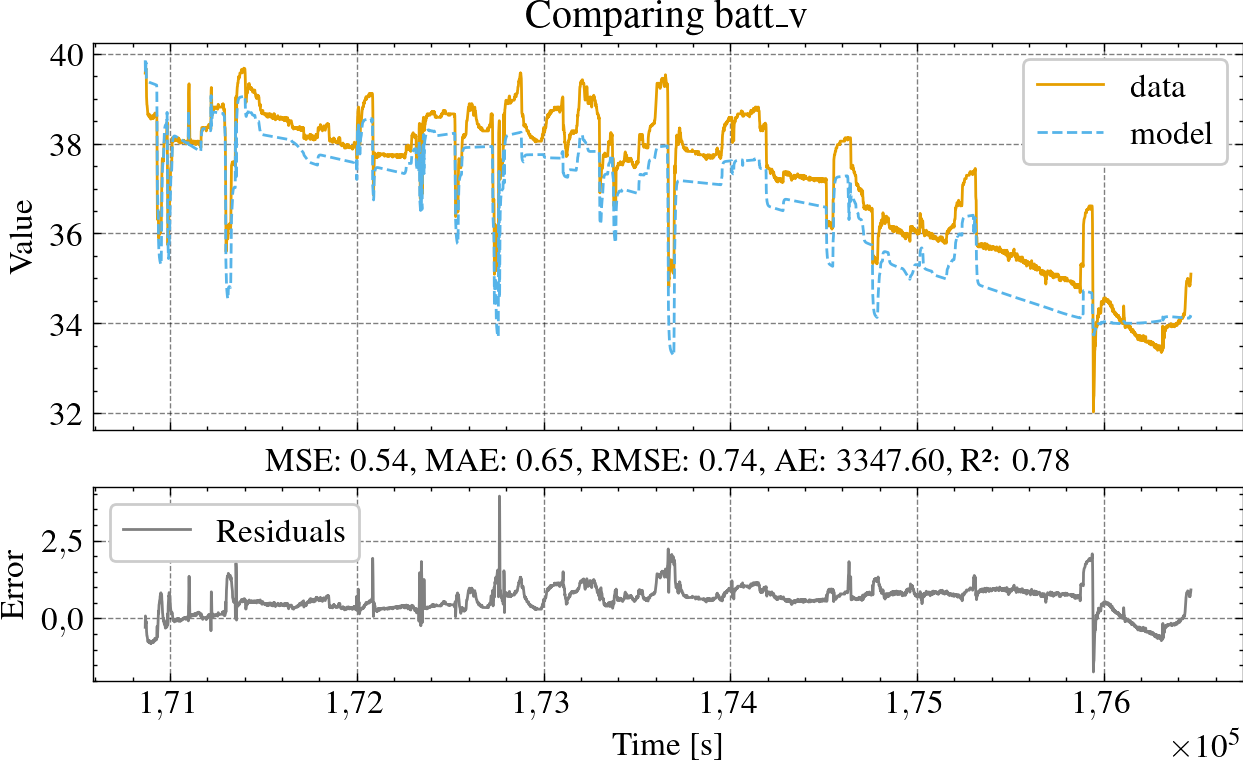

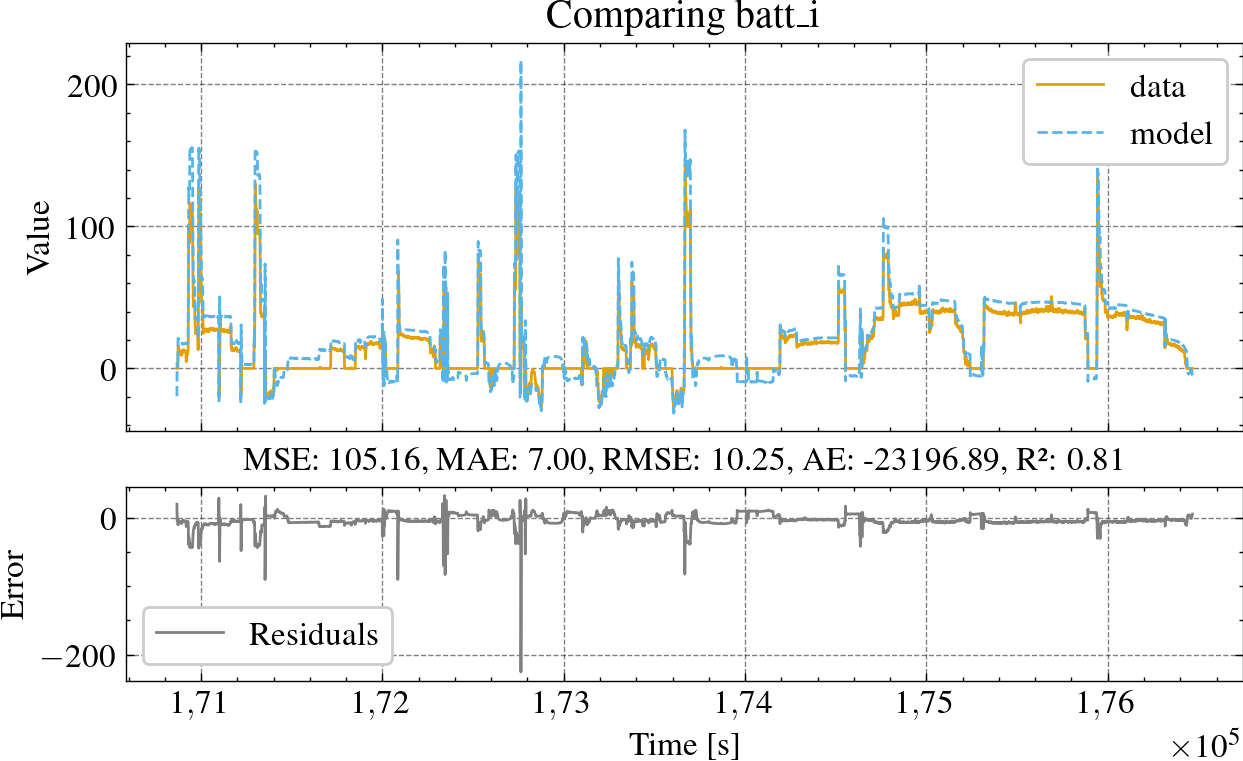

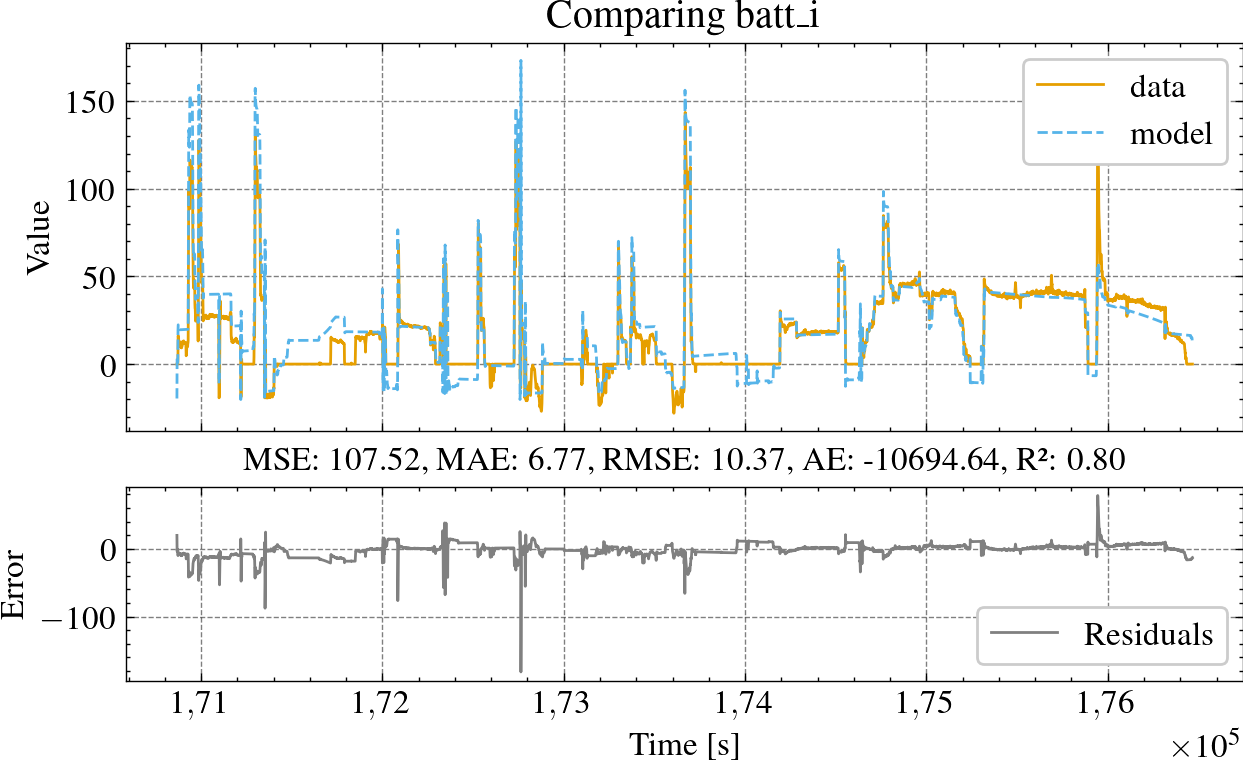

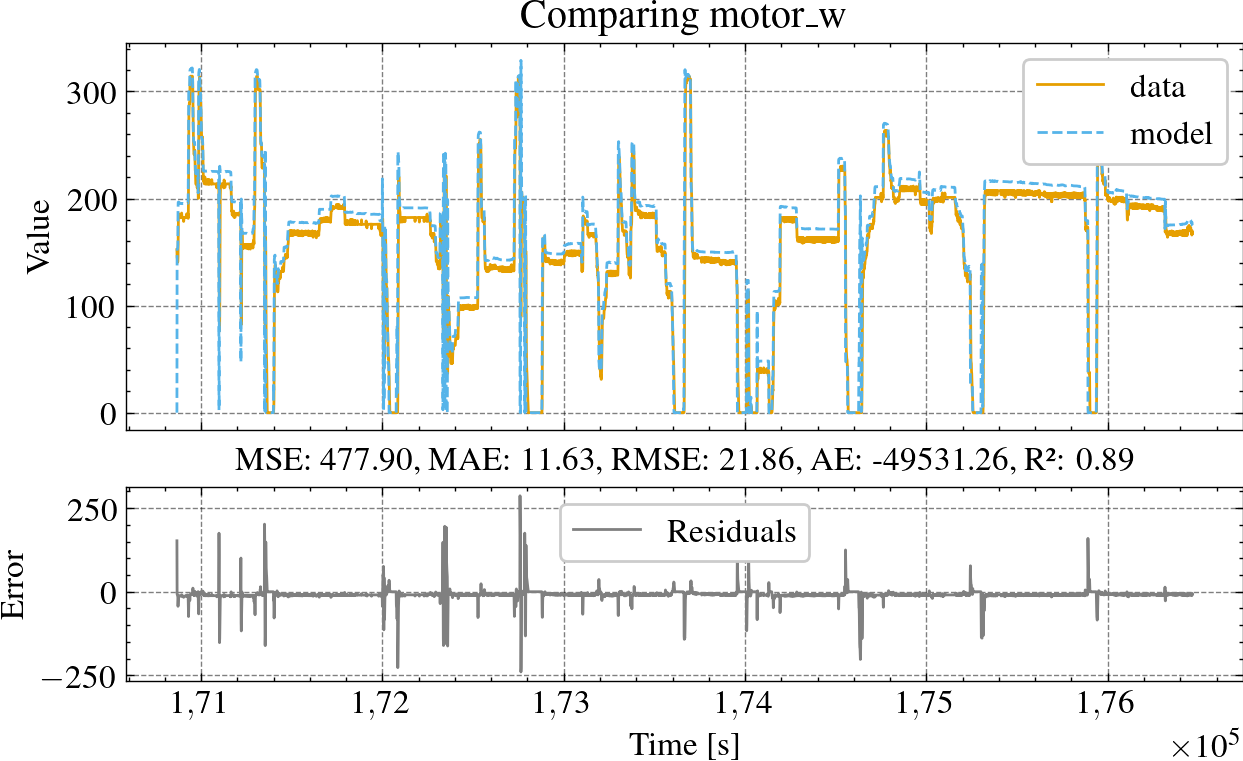

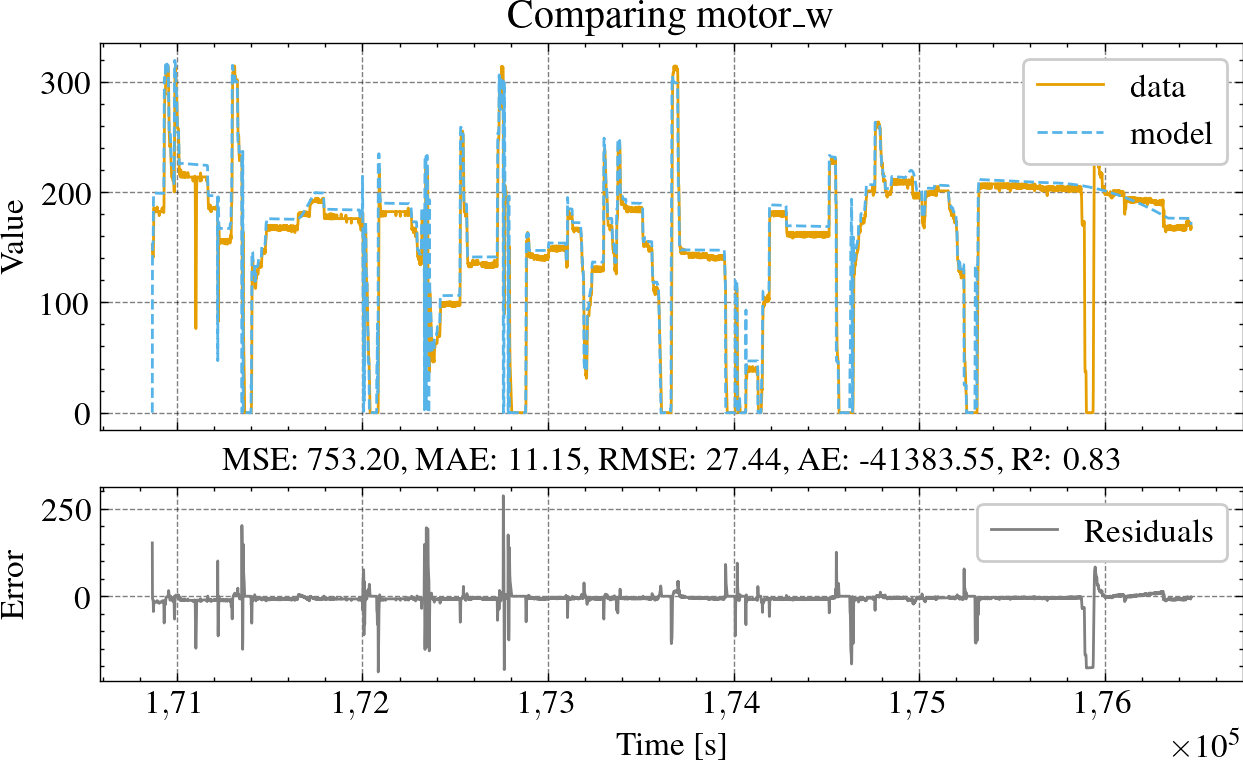

In [40]:
# Data selection
section_name = "Section D23"
section = next(s for s in all_sections if s["name"] == section_name)
df_section = df.loc[(df.index >= section["start"]) & (df.index <= section["end"])]

# Estimate signals from real data
df_hat = estimate_solar_boat_signals(df_section, solar_boat_params)

# Estimate signals from model
df_pred = simulate_solar_boat(df_section, solar_boat_params)

solar_boat_signals = SolarBoat.build(solar_boat_params)
data_cols = [c for c in list(df.columns) if c in solar_boat_signals.output_labels]
for column in data_cols:
    plot_compare(df_section, df_hat, column)
    plot_compare(df_section, df_pred, column)

In [41]:
from utils.control import get_steady_state_map

def model_function(T, U, X0, **params) -> pd.DataFrame:
    return ct.input_output_response(
        SolarBoatFull.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method='Radau',
    ).to_pandas()

df_pred_ss = get_steady_state_map(
    model_class=SolarBoat,
    model_function=model_function,
    model_params=solar_boat_params,
    sweep_bounds={
        'pv_g': dict(min=df_pred["pv_g"].min(), max=df_pred["pv_g"].max()),
        'esc_d': dict(min=df_pred["esc_d"].min(), max=df_pred["esc_d"].max()),
    },
    sweep_steps=100,
    dt=60,
    ss_len=2,
    ss_tail_len=1,
)

display(df_pred_ss.describe())

pv_g         esc_d        batt_v        batt_i    batt_v_C_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     675.270825      0.500000     31.762422     17.310493      0.086882   
std      149.451535      0.291591      1.207298     35.161745      0.176406   
min      419.001750      0.000000     28.753168    -23.565963     -0.118084   
25%      547.136288      0.250000     30.895649    -12.023397     -0.060252   
50%      675.270825      0.500000     32.210171      4.307822      0.021591   
75%      803.405363      0.750000     32.768908     42.642046      0.213849   
max      931.539900      1.000000     33.162946    104.752122      0.525820   

         batt_v_C_2        batt_z     batt_v_oc    batt_p_out     batt_p_in  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.005144     -0.006324     10.763162    507.376783   -507.376783   
std        0.010205      0.012545      0.045888   1062.358084   1062.358084   
min       -0.006671     -0.037624     10.647084   -781.516753  -3011.955371   
25%       -0.003370     -0.015310     10.730824   -393.987353  -1317.451193   
50%        0.001361     -0.001674     10.780448    138.755690   -138.755690   
75%        0.012454      0.004142     10.801261   1317.451193    393.987353   
max        0.030605      0.008201     10.815665   3011.955371    781.516753   

       ...  prop_p_out_ow   prop_eta_ow        hull_u        hull_t  \
count  ...   10000.000000  10000.000000  10000.000000  10000.000000   
mean   ...     571.469182      0.619576      2.488270    168.760340   
std    ...     580.648642      0.075803      1.347167    137.481791   
min    ...       0.000000      0.000000      0.000000      0.000000   
25%    ...      49.647519      0.633617      1.351550     38.526213   
50%    ...     355.631682      0.633671      2.605905    143.164607   
75%    ...    1011.874023      0.633716      3.692964    287.442196   
max    ...    1912.633237      0.633769      4.566478    439.389251   

           hull_r_t     hull_p_in    hull_p_out      hull_eta  oth_p_in  \
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.0   
mean     168.795749    599.503753    599.722899      0.963613      27.0   
std      137.579702    609.133530    609.468888      0.157839       0.0   
min        0.000000      0.000000      0.000000      0.000000      27.0   
25%       38.517331     52.083078     52.071148      0.999699      27.0   
50%      143.171643    373.077910    373.096323      1.000050      27.0   
75%      287.532623   1061.513540   1061.847486      1.000341      27.0   
max      439.642650   2006.461310   2007.618453      1.000684      27.0   

           oth_i_in  
count  10000.000000  
mean       0.851331  
std        0.033442  
min        0.814162  
25%        0.823952  
50%        0.838245  
75%        0.873909  
max        0.939027  

[8 rows x 105 columns]

# Validations

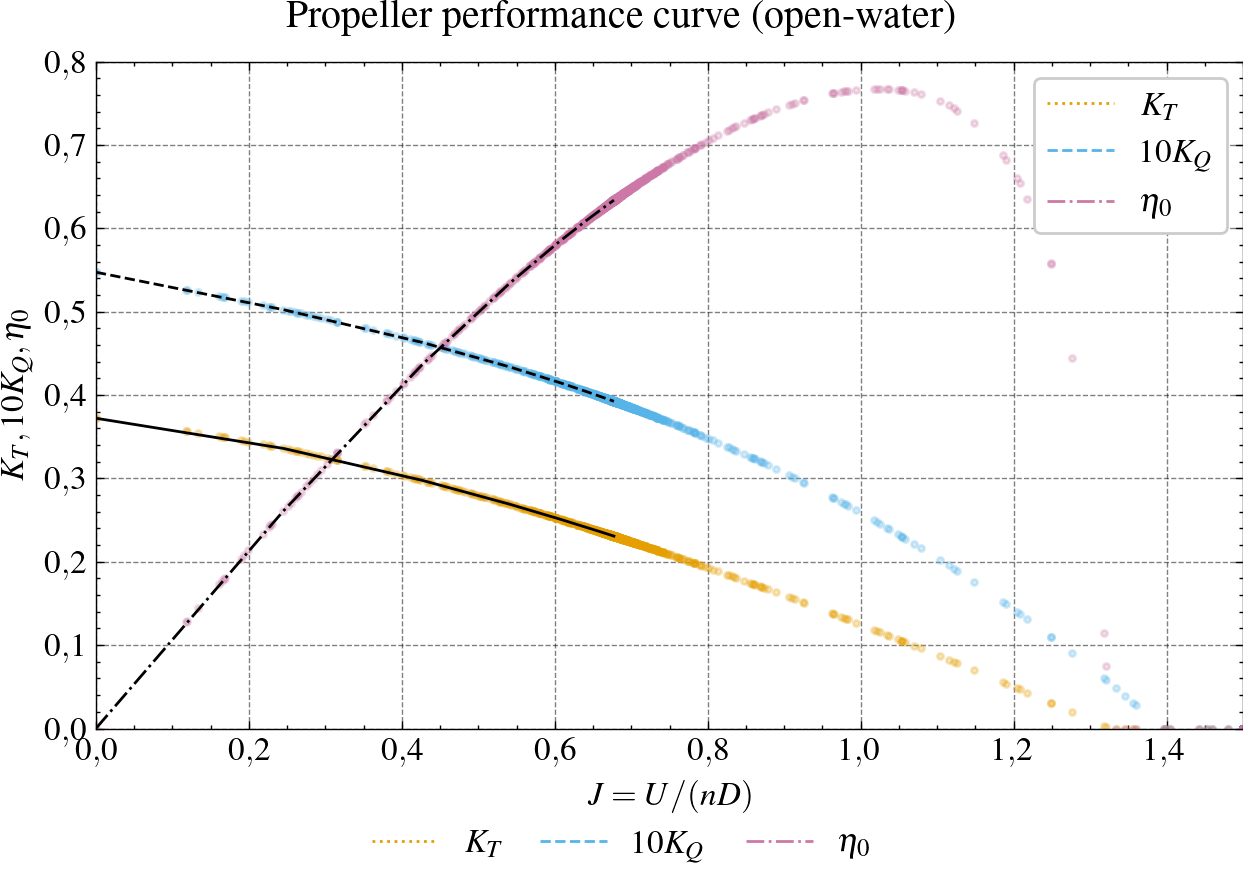

In [42]:
# 1. Classical propeller performance curve (K_T, 10K_Q, $\eta_0$ vs J)

df_prop_ss = df_pred_ss.copy().sort_values('prop_j')

fig, ax = plt.subplots(figsize=figsize(), layout='constrained')


# Plot steady-state curves (lines) and dataset samples (markers)
ax.plot(df_prop_ss['prop_j'], df_prop_ss['prop_k_t_ow'], color='k')
ax.plot(df_prop_ss['prop_j'], 10.0 * df_prop_ss['prop_k_q_ow'], color='k')
ax.plot(df_prop_ss['prop_j'], df_prop_ss['prop_eta_ow'], color='k')

ax.scatter(df_pred['prop_j'], df_pred['prop_k_t_ow'], s=5, alpha=0.25, color='C0')
ax.scatter(df_pred['prop_j'], 10.0 * df_pred['prop_k_q_ow'], s=5, alpha=0.25, color='C1')
ax.scatter(df_pred['prop_j'], df_pred['prop_eta_ow'], s=5, alpha=0.25, color='C2')

ax.plot(np.nan, np.nan, color='C0', label='$K_T$')
ax.plot(np.nan, np.nan, color='C1', label='$10K_Q$')
ax.plot(np.nan, np.nan, color='C2', label='$\\eta_0$')

ax.set_xlabel('$J = U / (n D)$')
ax.set_ylabel('$K_T, 10K_Q, \\eta_0$')
ax.set_xlim((0, 1.5))

ax.set_ylim((0, 0.8))
ax.grid(True)
ax.legend(loc='best')
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_propeller_performance_curve.pdf",
    show_title='Propeller performance curve (open-water)',
    save_title='Curva clássica de desempenho do hélice (open-water)',
    ncol=3,
    fig=fig,
    ax=ax,
)


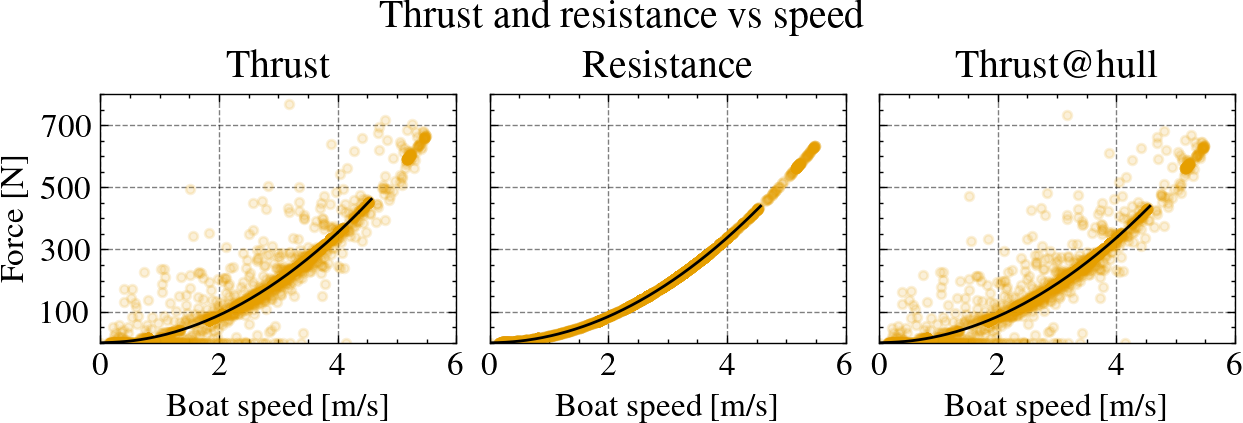

In [43]:
# 2. Boat performance curve (thrust vs resistance vs speed)

df_hull_ss = df_pred_ss.copy().sort_values('hull_u')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize(subplots=(1,2)), sharex=True, sharey=True, layout='constrained')

# Dataset points (markers only)
ax[0].scatter(df_pred['hull_u'], df_pred['prop_t_ow'], s=10, alpha=0.15, color='C0')
ax[1].scatter(df_pred['hull_u'], df_pred['hull_r_t'], s=10, alpha=0.15, color='C0')
ax[2].scatter(df_pred['hull_u'], df_pred['hull_t'], s=10, alpha=0.15, color='C0')

# Steady-state curves
ax[0].plot(df_hull_ss['hull_u'], df_hull_ss['prop_t_ow'], color='k')
ax[1].plot(df_hull_ss['hull_u'], df_hull_ss['hull_r_t'], color='k')
ax[2].plot(df_hull_ss['hull_u'], df_hull_ss['hull_t'], color='k')

ax[0].set_title(label='Thrust')
ax[1].set_title(label='Resistance')
ax[2].set_title(label='Thrust@hull')

ax[0].set_ylabel('Force [N]')
for axi in ax:
    axi.set_xlabel('Boat speed [m/s]')
    axi.grid(True)
    axi.set_yticks(range(100, 900, 200))
    axi.set_xticks(range(0, 8, 2))
    axi.set_xlim((0, 6))
    axi.set_ylim((0, 800))
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_thrust_resistance_vs_speed.pdf",
    show_title='Thrust and resistance vs speed',
    save_title='Empuxo e resistência em função da velocidade',
    ncol=1,
    fig=fig,
    ax=ax,
)


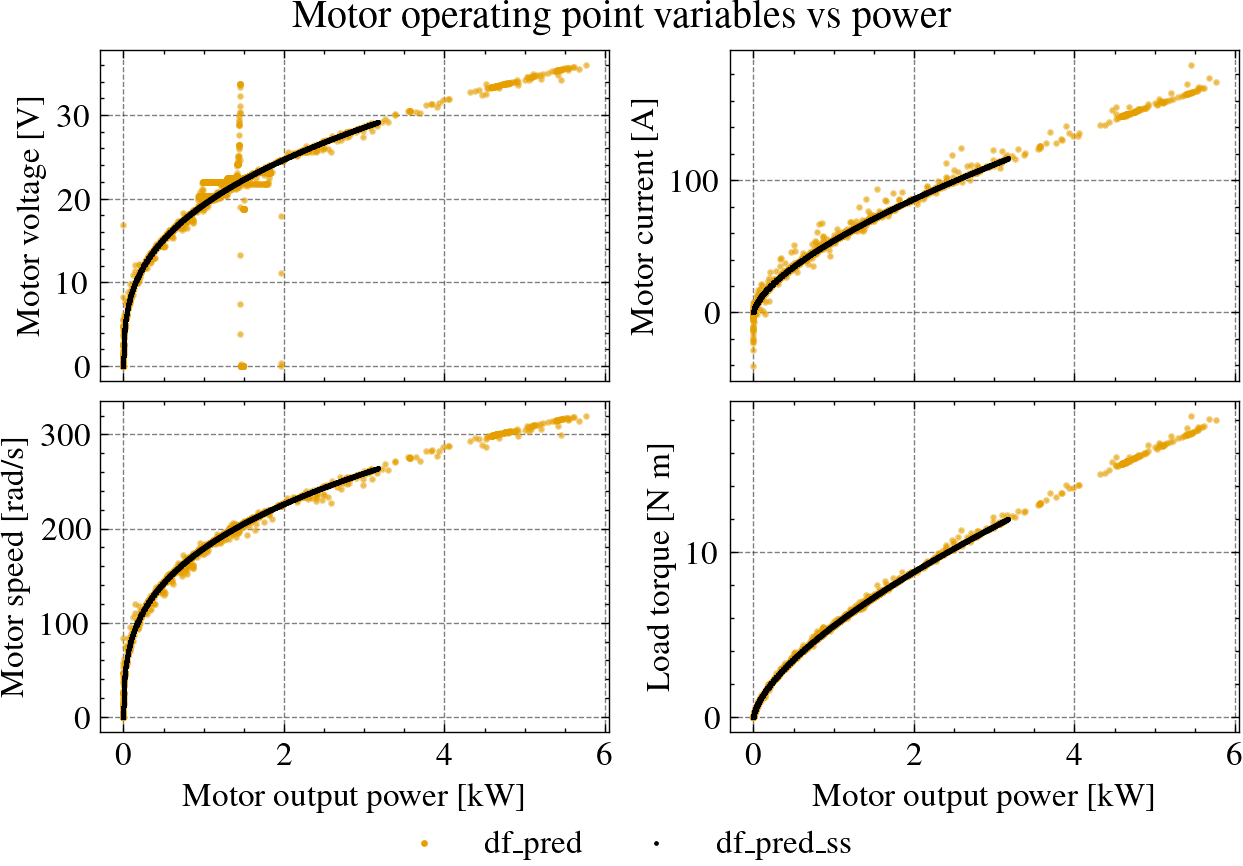

In [44]:
# Compare operating point variables vs motor output power (df_pred vs df_pred_ss)

xcol = 'motor_p_out'

pairs = [
    ('motor_v', 'Motor voltage [V]'),
    ('motor_i', 'Motor current [A]'),
    ('motor_w', 'Motor speed [rad/s]'),
    ('motor_q_load', 'Load torque [N m]'),
]

fig, axes = plt.subplots(2, 2, figsize=figsize(subplots=(2,2)), sharex=True, constrained_layout=True)
axes = axes.reshape(-1)

for ax, (ycol, ylab) in zip(axes, pairs):
    ax.scatter(1e-3*df_pred[xcol].astype(float), df_pred[ycol].astype(float), s=2, alpha=0.5, color='C0', label='df_pred')
    ax.scatter(1e-3*df_pred_ss[xcol].astype(float), df_pred_ss[ycol].astype(float), s=0.5, alpha=0.5, color='k', label='df_pred_ss')

    ax.set_ylabel(ylab)
    ax.grid(True)

for ax in axes[-2:]:
    ax.set_xlabel('Motor output power [kW]')

# Single legend outside
handles, labels = axes[0].get_legend_handles_labels()
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_motor_operating_point_vs_power.pdf",
    show_title='Motor operating point variables vs power',
    save_title='Variáveis do ponto de operação do motor em função da potência',
    ncol=2,
    fig=fig,
    ax=axes[0],
)


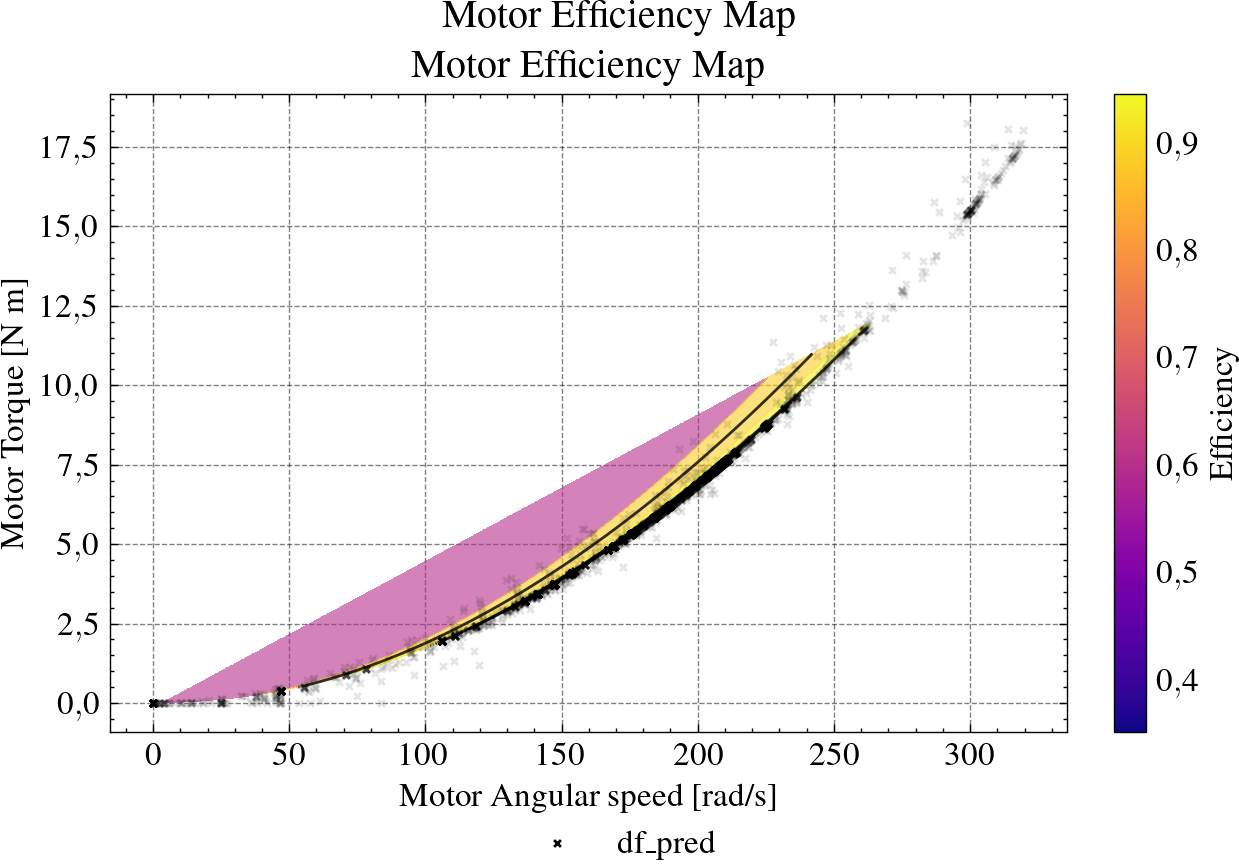

In [45]:
fig, ax, out = plot_efficiency_map_scattered(
    df_pred_ss,
    x="motor_w",
    y="motor_q_load",
    z="motor_eta",
    nx=1200,
    ny=1200,
    mask_col="motor_p_out",
    mask_min=0,
    level_pmin=0,
    level_pmax=100,
    level_n=10,
    contour_lines=True,
    line_pmin=0,
    line_pmax=95,
    line_n=7,
    line_colors="k",
    label_lines=0,
    title="Motor Efficiency Map",
    xlabel="Motor Angular speed [rad/s]",
    ylabel="Motor Torque [N m]",
    cbar_label="Efficiency",
    cmap="plasma",
    fill_alpha=0.6,
)
ax.scatter(
    df_pred["motor_w"],
    df_pred["motor_q_load"],
    marker='x',
    c='k',
    vmin=0,
    vmax=1,
    s=6,
    alpha=0.1,
    edgecolors="none",
    label="df_pred",
)
# ax.legend(loc="best")
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_motor_efficiency_map.pdf",
    show_title='Motor Efficiency Map',
    save_title='Mapa de eficiência do moto',
    ncol=1,
    fig=fig,
    ax=ax,
)


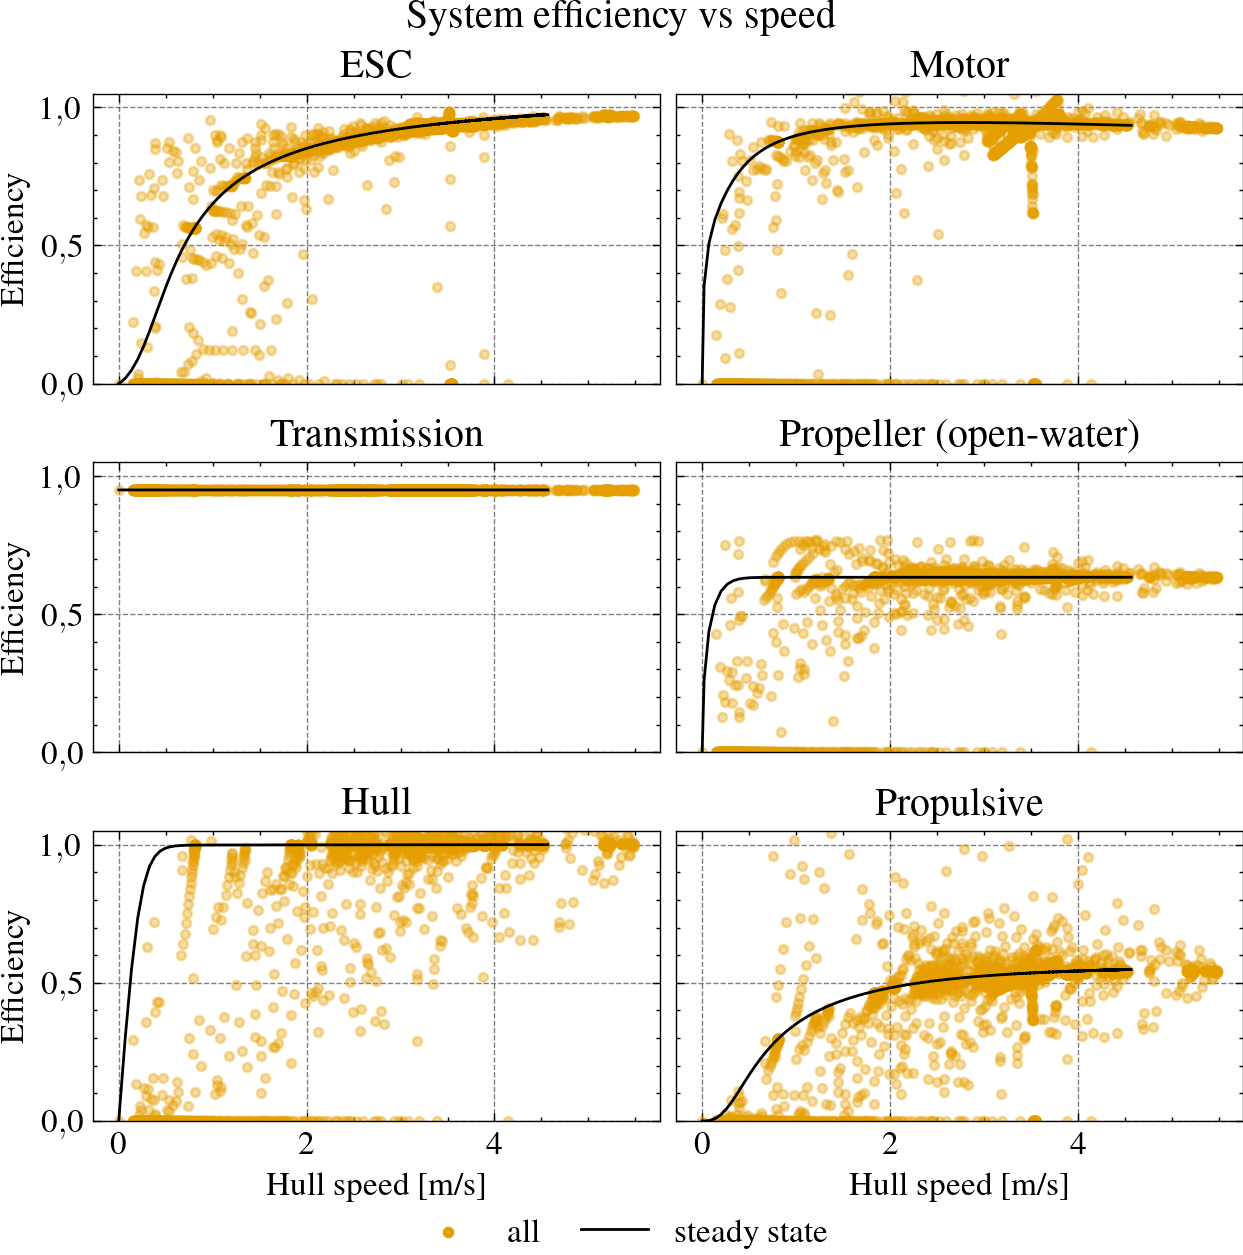

In [46]:
# B. Efficiency vs speed at operating point (steady-state line + dataset markers)

df_eta_ss = df_pred_ss.copy()
df_eta_data = df_pred.copy()

df_eta_ss['propulsive_eta'] = df_eta_ss['esc_eta'] * df_eta_ss['motor_eta'] * df_eta_ss['trans_eta'] * df_eta_ss['prop_eta_ow'] * df_eta_ss['hull_eta']
df_eta_data['propulsive_eta'] = df_eta_data['esc_eta'] * df_eta_data['motor_eta'] * df_eta_data['trans_eta'] * df_eta_data['prop_eta_ow'] * df_eta_data['hull_eta']

u_max = float(np.nanmax([df_eta_ss['hull_u'].max(), df_eta_data['hull_u'].max()]))
u_bins = np.linspace(0.0, u_max, 10000)
# df_eta_ss['hull_u_bin'] = pd.cut(df_eta_ss['hull_u'], bins=u_bins)
# df_eta_data['hull_u_bin'] = pd.cut(df_eta_data['hull_u'], bins=u_bins)

df_eta_ss['hull_u_bin'] = df_eta_ss['hull_u']
df_eta_data['hull_u_bin'] = df_eta_data['hull_u']

eta_cols = ['esc_eta', 'motor_eta', 'trans_eta', 'prop_eta_ow', 'hull_eta', 'propulsive_eta']

df_eta_ss_u = (
    df_eta_ss.groupby('hull_u_bin', observed=True)
    .agg(hull_u=('hull_u', 'mean'), **{c: (c, 'mean') for c in eta_cols})
    .reset_index(drop=True)
    # .dropna()
    .sort_values('hull_u')
)

df_eta_data_u = (
    df_eta_data.groupby('hull_u_bin', observed=True)
    .agg(hull_u=('hull_u', 'mean'), **{c: (c, 'mean') for c in eta_cols})
    .reset_index(drop=True)
    # .dropna()
    .sort_values('hull_u')
)

ncols = 2
nrows = int(np.ceil(len(eta_cols) / ncols))

fig_w, fig_h = figsize(subplots=(nrows, ncols))

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(fig_w, fig_h),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
axes = np.asarray(axes).reshape(-1)

titles = {
    'esc_eta': 'ESC',
    'motor_eta': 'Motor',
    'trans_eta': 'Transmission',
    'prop_eta_ow': 'Propeller (open-water)',
    'hull_eta': 'Hull',
    'propulsive_eta': 'Propulsive',
}

for i, c in enumerate(eta_cols):
    ax = axes[i]
    ax.scatter(df_eta_data_u['hull_u'], df_eta_data_u[c], color='C0', s=10, alpha=0.35, label='all')
    ax.plot(df_eta_ss_u['hull_u'], df_eta_ss_u[c], lw=1, color='k', label='steady state')
    ax.set_title(titles.get(c, c))
    ax.set_ylim(0, 1.05)
    ax.grid(True)
    if i % ncols == 0:
        ax.set_ylabel('Efficiency')

for j in range(len(eta_cols), len(axes)):
    axes[j].axis('off')

for ax in axes[max(0, len(axes) - ncols):]:
    ax.set_xlabel('Hull speed [m/s]')

fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_system_efficiency_decomposed.pdf",
    show_title='System efficiency vs speed',
    save_title='Eficiência do sistema em função da velocidade',
    ncol=3,
    fig=fig,
    ax=axes[0],
)


## Validação do sistema (end-to-end)

Além das curvas do hélice e do balanço empuxo–resistência, é útil checar se o modelo fecha o balanço de potência e qual é o custo energético por distância (Wh/km).

- Convenção de sinais: `batt_i > 0` durante descarga (bateria fornecendo potência ao barramento DC).  
- Usam-se grandezas no barramento CC já estimadas em `df_hat`: `batt_v`, `batt_i`, `mppts_i_out`, `esc_i_in`, `oth_i_in` (fechamento por KCL) e `esc_p_in` (para Wh/km).  


In [47]:
# System power balance and energy-per-distance metrics
# NOTE: the DC bus closes in *current* (KCL) at v_Batt(t). Using mixed power signals
# from different subsystems can create apparent non-closure.

df_sys = df_pred.copy()
required_cols = ['batt_v', 'batt_i', 'mppts_i_out', 'esc_i_in', 'oth_i_in', 'esc_p_in', 'hull_u', 'esc_d']
missing = [c for c in required_cols if c not in df_sys.columns]
if missing:
    raise KeyError(f'Missing required columns for system validation: {missing}')

df_sys = df_sys.dropna(subset=required_cols).copy()

# DC bus current closure (positive into the bus)
df_sys['bus_i_in'] = df_sys['mppts_i_out'] + df_sys['batt_i']
df_sys['bus_i_out'] = df_sys['esc_i_in'] + df_sys['oth_i_in']
df_sys['bus_i_err'] = df_sys['bus_i_in'] - df_sys['bus_i_out']

# Convert to power error at the bus voltage (v_Batt)
df_sys['bus_p_in'] = df_sys['batt_v'] * df_sys['bus_i_in']
df_sys['bus_p_out'] = df_sys['batt_v'] * df_sys['bus_i_out']
df_sys['bus_p_err'] = df_sys['batt_v'] * df_sys['bus_i_err']
df_sys['bus_p_err_rel'] = df_sys['bus_p_err'] / np.maximum(np.abs(df_sys['bus_p_out']), 1.0)

# Filter out near-zero speed points (avoids Wh/km blow-up)
df_sys = df_sys[df_sys['hull_u'] > 0.2].copy()
df_sys['boat_e_wh_per_km'] = (df_sys['esc_p_in'] / df_sys['hull_u']) * (1000.0 / 3600.0)

df_sys[['batt_v','mppts_i_out','batt_i','esc_i_in','oth_i_in','bus_i_err','bus_p_err','boat_e_wh_per_km']].describe().T

count          mean           std           min        25%  \
batt_v            5568.0  3.661237e+01  1.539026e+00  3.328113e+01  35.144443   
mppts_i_out       5568.0  1.459741e+01  2.757003e+00  9.830303e+00  12.334006   
batt_i            5568.0  2.008849e+01  2.645417e+01 -2.020133e+01   2.177193   
esc_i_in          5568.0  3.394712e+01  2.676112e+01 -3.424365e+00  17.321941   
oth_i_in          5568.0  7.387899e-01  3.176122e-02  6.783055e-01   0.713775   
bus_i_err         5568.0 -1.349894e-17  2.880716e-15 -2.842171e-14   0.000000   
bus_p_err         5568.0 -5.142535e-16  1.039024e-13 -1.033762e-12   0.000000   
boat_e_wh_per_km  5568.0  1.011352e+02  5.693500e+01 -1.207492e+01  71.483603   

                         50%         75%           max  
batt_v             37.159019   37.827053  3.980507e+01  
mppts_i_out        15.014199   16.505678  2.230647e+01  
batt_i             18.234540   36.760287  1.730788e+02  
esc_i_in           32.725212   47.551878  1.913126e+02  
oth_i_in            0.726607    0.768258  8.112705e-01  
bus_i_err           0.000000    0.000000  2.842171e-14  
bus_p_err           0.000000    0.000000  1.021969e-12  
boat_e_wh_per_km  107.747877  132.992917  6.203939e+02

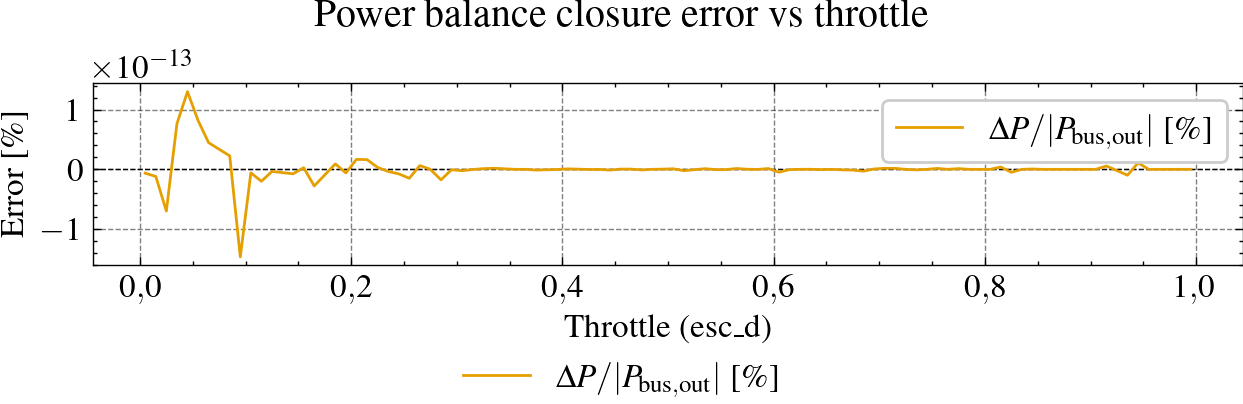

In [48]:
# Power balance closure: absolute and relative error vs throttle
nbins = 100
df_sys['pilot_bin_idx'] = np.clip((df_sys['esc_d'] * nbins).astype(int), 0, nbins - 1)
df_sys['pilot_bin_mid'] = (df_sys['pilot_bin_idx'] + 0.5) / nbins

g = df_sys.groupby('pilot_bin_idx', as_index=False)
df_balance = g.agg(
    esc_d=('pilot_bin_mid', 'mean'),
    n=('pilot_bin_mid', 'size'),
    bus_p_in=('bus_p_in', 'mean'),
    bus_p_out=('bus_p_out', 'mean'),
    bus_p_err=('bus_p_err', 'mean'),
    bus_p_err_rel=('bus_p_err_rel', 'mean'),
).sort_values('esc_d')

fig, ax = plt.subplots(1, 1, figsize=figsize(subplots=(0.4, 1)), layout='constrained')
ax.axhline(0, color='k', lw=0.5, linestyle='--')
ax.plot(df_balance['esc_d'], 100*df_balance['bus_p_err_rel'], label='$\\Delta P / |P_{\\mathrm{bus,out}}|$ [\\%]')

ax.set_xlabel('Throttle (esc_d)')
ax.set_ylabel('Error [\\%]')
ax.grid(True)
ax.legend(loc='best')
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_power_balance_error_vs_throttle.pdf",
    show_title='Power balance closure error vs throttle',
    save_title='Erro de fechamento do balanço de potência em função do throttle',
    ncol=1,
    fig=fig,
    ax=ax,
)


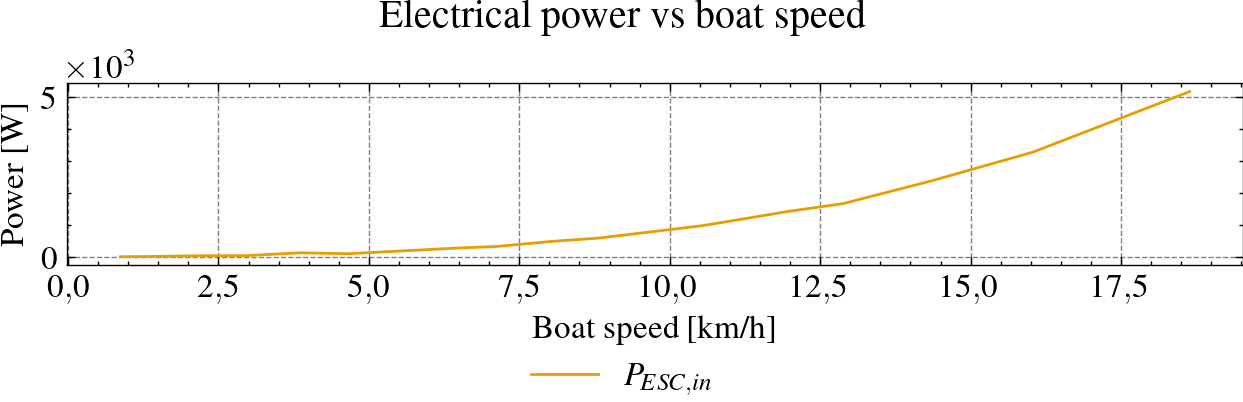

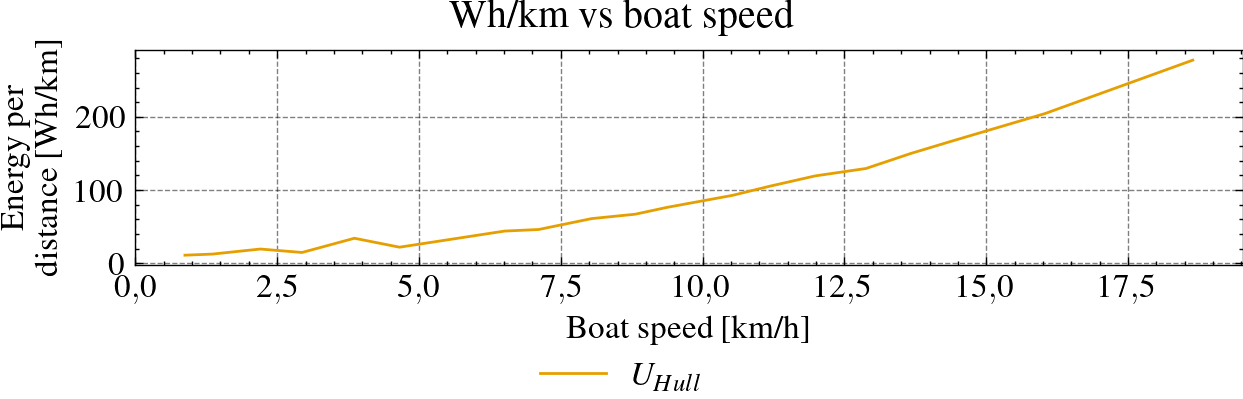

U_opt_range_mps  Wh_per_km_opt  P_elec_opt_W  U_max_mps  P_elec_max_W
0         0.873434      10.947416       9.27835  18.641621   5171.654141

In [49]:
# Electrical power and energy-per-distance vs speed

df_sys['hull_u_kmph'] = df_sys['hull_u'] * 3.6

u_max = float(np.nanmax(df_sys['hull_u_kmph']))
u_bins = np.linspace(0.2, u_max, 25)
df_sys['hull_u_kmph_bin'] = pd.cut(df_sys['hull_u_kmph'], bins=u_bins)

df_u = (
    df_sys.groupby('hull_u_kmph_bin', observed=True)
    .agg(
        U=('hull_u_kmph', 'mean'),
        n=('hull_u_kmph', 'size'),
        P_elec=('esc_p_in', 'mean'),
        boat_e_wh_per_km=('boat_e_wh_per_km', 'mean'),
    )
    .reset_index(drop=True)
)
df_u = df_u[df_u['n'] >= 50].sort_values('U')

fig, ax = plt.subplots(1, 1, figsize=figsize(subplots=(0.4,1)), layout="constrained")
ax.plot(df_u['U'], df_u['P_elec'], ms=3, label='$P_{ESC,in}$')
ax.set_xlabel('Boat speed [km/h]')
ax.set_ylabel('Power [W]')
ax.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_power_vs_speed.pdf",
    show_title='Electrical power vs boat speed',
    save_title='Potência elétrica em função da velocidade da embarcação',
    ncol=2,
    fig=fig,
    ax=ax,
)

fig, ax = plt.subplots(1, 1, figsize=figsize(subplots=(0.4,1)), layout="constrained")
ax.plot(df_u['U'], df_u['boat_e_wh_per_km'], ms=3, label='$U_{Hull}$')
ax.set_xlabel('Boat speed [km/h]')
ax.set_ylabel('Energy per\ndistance [Wh/km]')
ax.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_wh_per_km_vs_speed.pdf",
    show_title='Wh/km vs boat speed',
    save_title='Consumo (Wh/km) em função da velocidade da embarcação',
    ncol=2,
    fig=fig,
    ax=ax,
)

# Headline KPIs (from binned data)
best_idx = df_u['boat_e_wh_per_km'].idxmin() if len(df_u) else None
kpis = {}
if best_idx is not None and np.isfinite(best_idx):
    kpis['U_opt_range_mps'] = float(df_u.loc[best_idx, 'U'])
    kpis['Wh_per_km_opt'] = float(df_u.loc[best_idx, 'boat_e_wh_per_km'])
    kpis['P_elec_opt_W'] = float(df_u.loc[best_idx, 'P_elec'])

kpis['U_max_mps'] = float(df_u['U'].max()) if len(df_u) else np.nan
kpis['P_elec_max_W'] = float(df_u.loc[df_u['U'].idxmax(), 'P_elec']) if len(df_u) else np.nan

df_kpis = pd.DataFrame([kpis])
display(df_kpis)

kpis_table_latex = df_kpis.to_latex(
    index=False,
    caption="Indicadores de desempenho do modelo da embarcação solar",
    label="table:solar_boat_kpis_table",
    float_format="%.2f",
    column_format="|" + "c|" * (len(df_kpis.columns)),
    escape=True,
    decimal=',',
    position='H',
    multicolumn=True,
)
kpis_table_latex = (
    kpis_table_latex
    .replace('\\toprule', '\\hline')
    .replace('\\bottomrule\\n', '')
    .replace('\\midrule', '\\hline')
    .replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\\n\\end{table}')
    .replace('\\begin{tabular}', '\\centering\\n\\begin{tabular}')
)

with open(f"{latex_tex_path}/solar_boat_kpis_table.tex", "w") as f:
    f.write(kpis_table_latex)


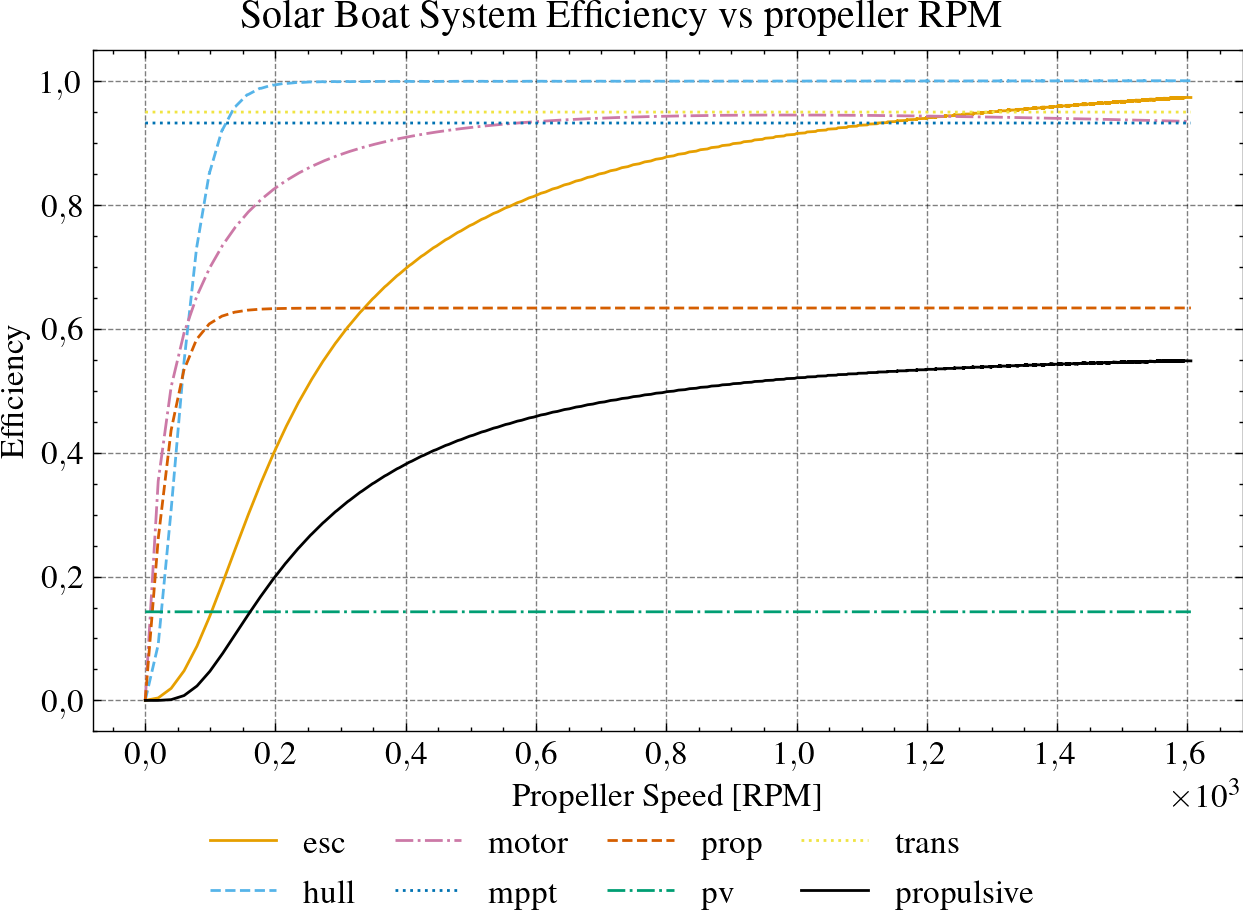

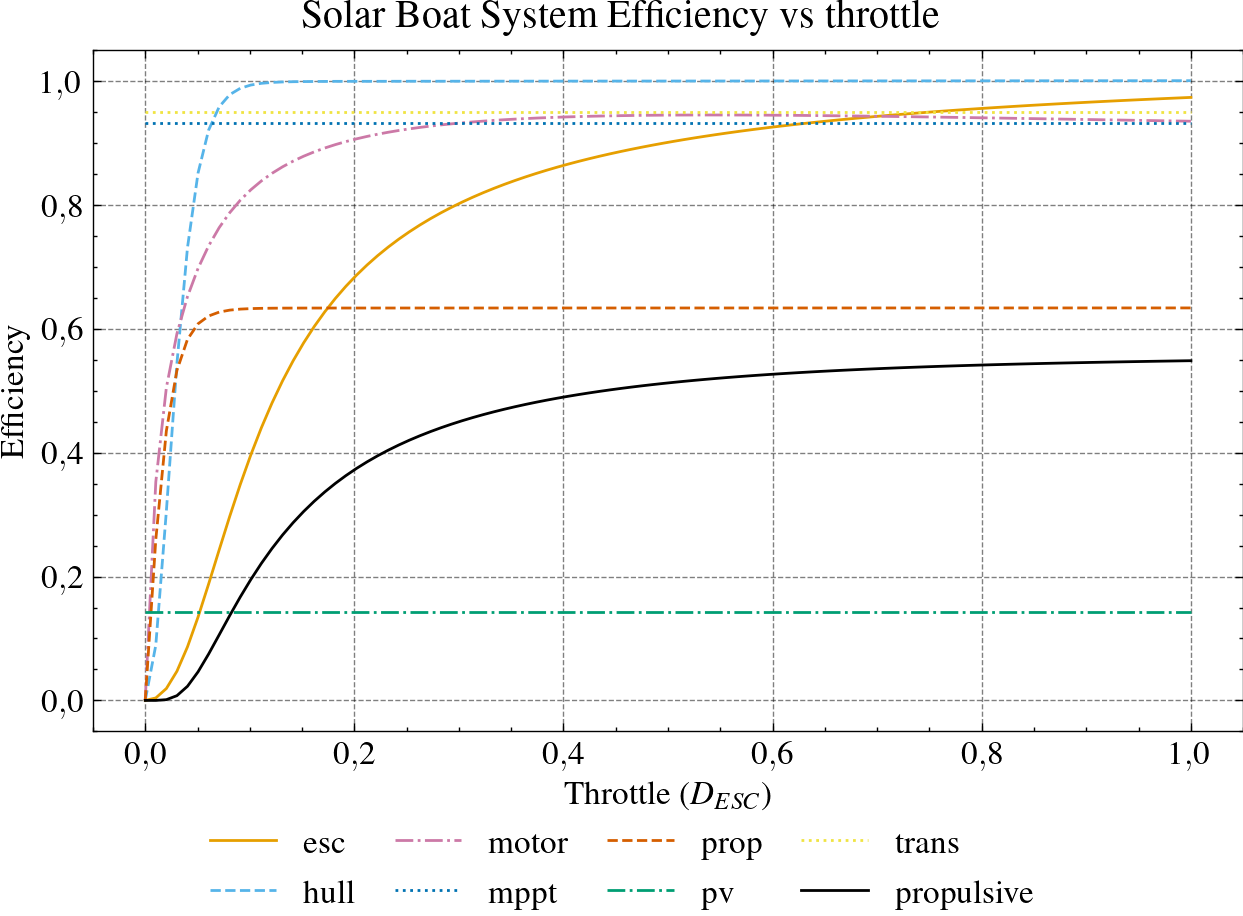

In [50]:
import math

eta_cols = sorted(set([c for c in df_pred_ss.columns if c.endswith('_eta')]))

df_pred_ss["propulsive_eta"] = (df_pred_ss["esc_eta"] * df_pred_ss["motor_eta"] * df_pred_ss["trans_eta"] * df_pred_ss["prop_eta"] * df_pred_ss["hull_eta"]).clip(0)

df_pred_ss['prop_rpm'] = df_pred_ss['prop_w'] * 60 / (2 * math.pi)
df_pred_ss2 = df_pred_ss.copy().groupby('prop_rpm').mean().reset_index()

fig = plt.figure(figsize=figsize(), layout='constrained')
for eta_col in eta_cols:
    if eta_col != 'propulsive_eta':
        plt.plot(df_pred_ss2['prop_rpm'], df_pred_ss2[eta_col], label=eta_col[:-4])
plt.plot(df_pred_ss2['prop_rpm'], df_pred_ss2["propulsive_eta"], label="propulsive", color='k')

plt.xlabel('Propeller Speed [RPM]')
plt.ylabel('Efficiency')
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_system_efficiency_vs_prop_rpm.pdf",
    show_title='Solar Boat System Efficiency vs propeller RPM',
    save_title='Eficiência do sistema da embarcação solar em função do RPM do hélice',
    ncol=4,
    fig=fig,
);

df_pred_ss3 = df_pred_ss.copy().groupby('esc_d').mean().reset_index()

fig = plt.figure(figsize=figsize(), layout='constrained')
for eta_col in eta_cols:
    if eta_col != 'propulsive_eta':
        plt.plot(df_pred_ss3['esc_d'], df_pred_ss3[eta_col], label=eta_col[:-4])
plt.plot(df_pred_ss3['esc_d'], df_pred_ss3["propulsive_eta"], label="propulsive", color='k')

plt.xlabel('Throttle ($D_{ESC}$)')
plt.ylabel('Efficiency')
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_system_efficiency_vs_throttle.pdf",
    show_title='Solar Boat System Efficiency vs throttle',
    save_title='Eficiência do sistema da embarcação solar em função do throttle',
    ncol=4,
    fig=fig,
);

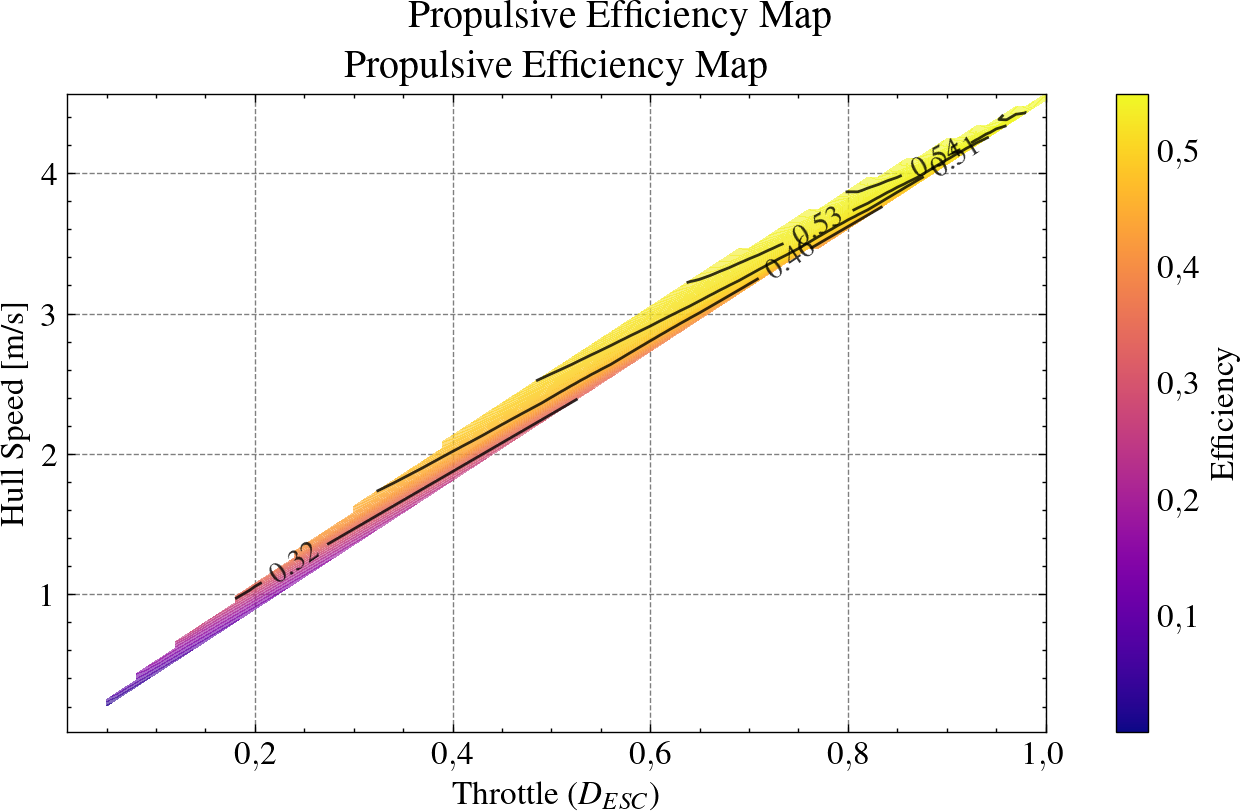

In [51]:

fig, ax, out = plot_efficiency_map_scattered(
    df_pred_ss,
    x="esc_d",
    y="hull_u",
    z="propulsive_eta",
    nx=100,
    ny=100,
    mask_col="motor_p_out",
    mask_min=0,
    level_pmin=0,
    level_pmax=100,
    level_n=100,
    contour_lines=True,
    line_pmin=0,
    line_pmax=95,
    line_n=7,
    line_colors="k",
    label_lines=1,
    title="Propulsive Efficiency Map",
    xlabel="Throttle ($D_{ESC}$)",
    ylabel="Hull Speed [m/s]",
    cbar_label="Efficiency",
    cmap="plasma",
    fill_alpha=0.6,
)
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_propulsive_efficiency_map.pdf",
    show_title='Propulsive Efficiency Map',
    save_title='Mapa de eficiência propulsiva',
    ncol=1,
    fig=fig,
    ax=ax,
)


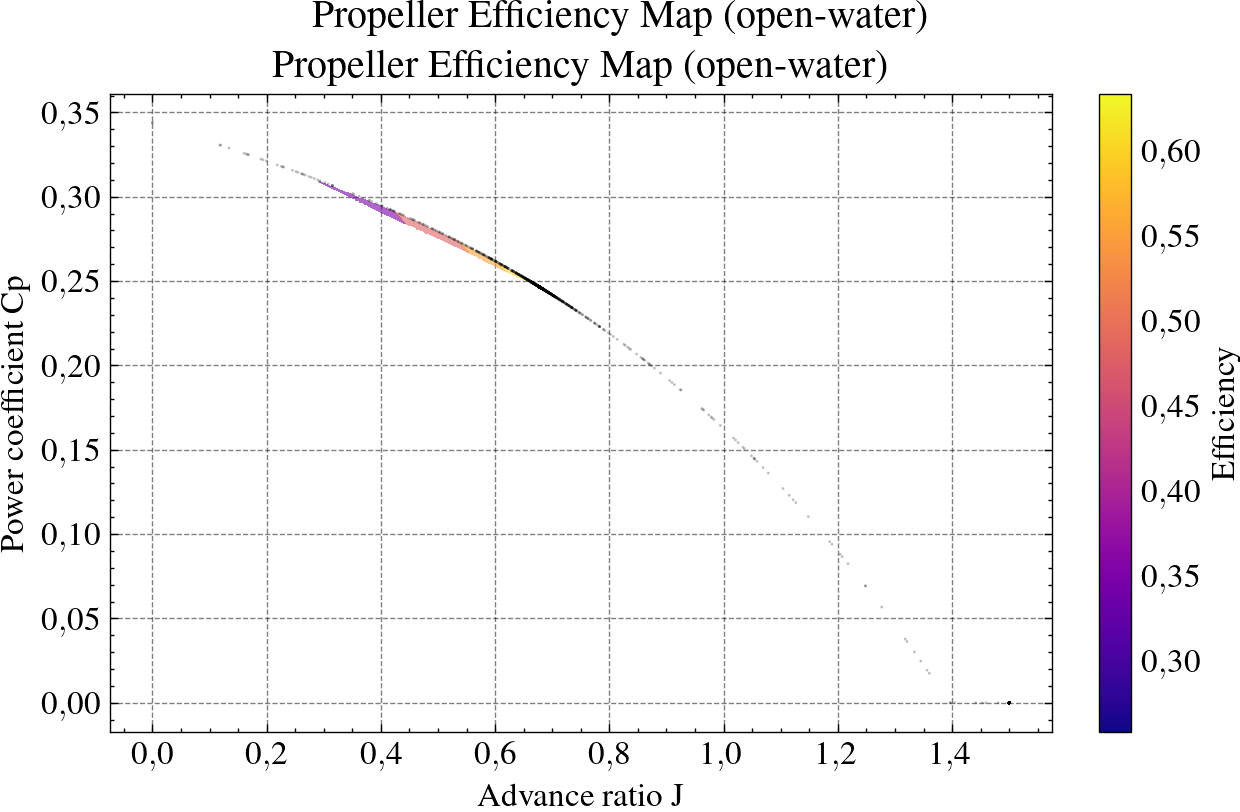

In [52]:
# Propeller performance map: x=J, y=Cp, z=eta (steady-state + dataset markers)

# Cp (power coefficient) is defined as: Cp = P / (rho n^3 D^5) = 2*pi*K_Q
# Here we use the open-water torque coefficient prop_k_q_ow -> Cp_ow
df_pred_ss['prop_c_p_ow'] = 2 * np.pi * df_pred_ss['prop_k_q_ow']
df_pred['prop_c_p_ow'] = 2 * np.pi * df_pred['prop_k_q_ow']

fig, ax, out = plot_efficiency_map_scattered(
    df_pred_ss,
    x='prop_j',
    y='prop_c_p_ow',
    z='prop_eta_ow',
    nx=120,
    ny=120,
    mask_col='prop_p_out_ow',
    mask_min=0,
    level_pmin=0,
    level_pmax=100,
    level_n=100,
    contour_lines=True,
    line_pmin=0,
    line_pmax=95,
    line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propeller Efficiency Map (open-water)',
    xlabel='Advance ratio J',
    ylabel='Power coefficient Cp',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)

# Overlay dataset points as markers only
ax.scatter(df_pred['prop_j'], df_pred['prop_c_p_ow'], c='k', s=1, alpha=0.25, edgecolors='none')
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_propeller_efficiency_map.pdf",
    show_title='Propeller Efficiency Map (open-water)',
    save_title='Mapa de eficiência do hélice (open-water)',
    ncol=1,
    fig=fig,
    ax=ax,
)


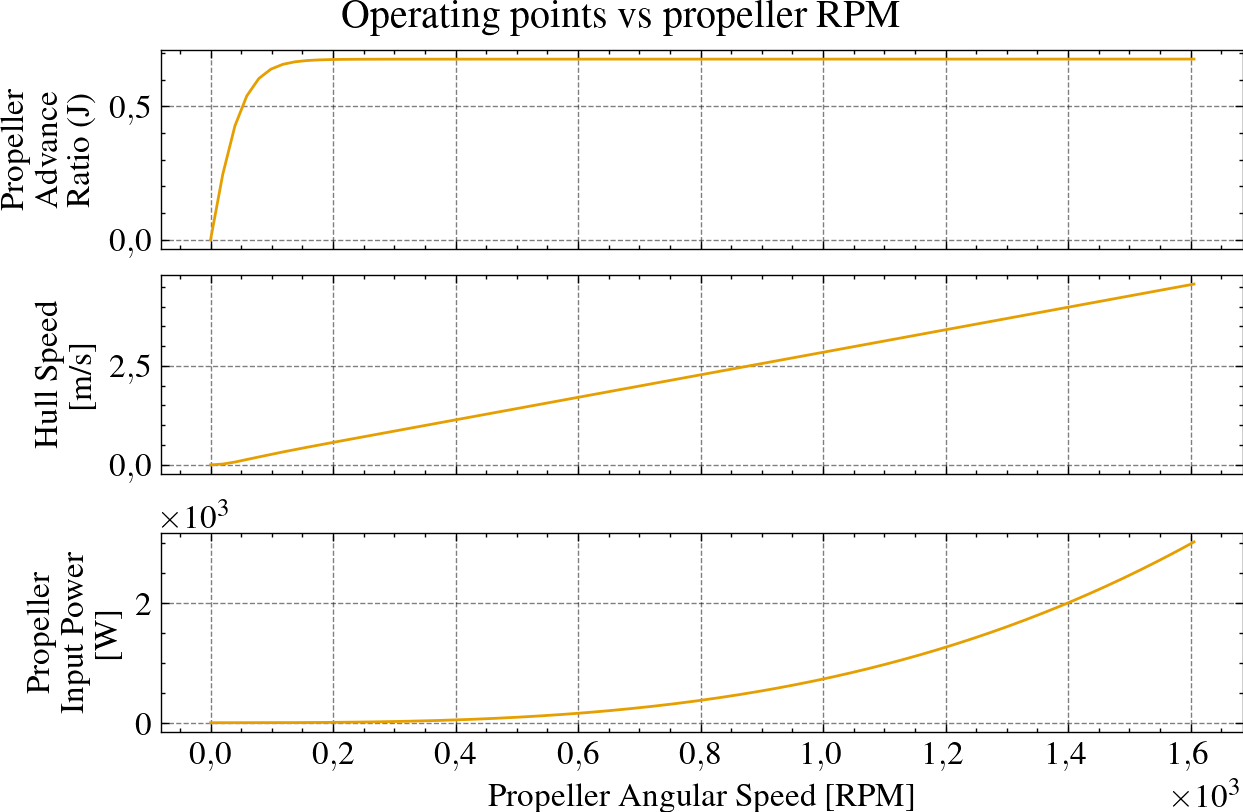

In [53]:
df_prop_w = df_pred_ss.sort_values('prop_w')
df_prop_w["prop_rpm"] = df_prop_w["prop_w"] * 60 / (2*math.pi)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=figsize(subplots=(1,1)), sharex=True, layout='constrained')


ax[0].plot(df_prop_w["prop_rpm"], df_prop_w["prop_j"])
ax[0].set_ylabel("Propeller\nAdvance\nRatio (J)")

ax[1].plot(df_prop_w["prop_rpm"], df_prop_w["hull_u"])
ax[1].set_ylabel("Hull Speed\n[m/s]")

ax[2].plot(df_prop_w["prop_rpm"], df_prop_w["prop_p_in"])
ax[2].set_ylabel("Propeller\nInput Power\n[W]")

ax[-1].set_xlabel("Propeller Angular Speed [RPM]")
fig_save_and_show(
    filename=f"{latex_img_path}/solar_boat_propeller_operating_points_vs_rpm.pdf",
    show_title='Operating points vs propeller RPM',
    save_title='Pontos de operação em função do RPM do hélice',
    ncol=1,
    fig=fig,
    ax=ax,
)
